In [1]:
#! pip install torch-summary #for visualizing the model


In [2]:
#download dataset
!wget --load-cookies /tmp/cookies.txt "https://docs.google.com/uc?export=download&confirm=$(wget --quiet --save-cookies /tmp/cookies.txt --keep-session-cookies --no-check-certificate 'https://docs.google.com/uc?export=download&id=1NPMGpcdM9OEiv9j40axB-ikKyz1N38mv' -O- | sed -rn 's/.*confirm=([0-9A-Za-z_]+).*/\1\n/p')&id=1NPMGpcdM9OEiv9j40axB-ikKyz1N38mv" -O euroSAT_tvt_pkl.zip && rm -rf /tmp/cookies.txt

--2022-04-05 15:25:39--  https://docs.google.com/uc?export=download&confirm=t&id=1NPMGpcdM9OEiv9j40axB-ikKyz1N38mv
Resolving docs.google.com (docs.google.com)... 142.250.148.113, 142.250.148.102, 142.250.148.139, ...
Connecting to docs.google.com (docs.google.com)|142.250.148.113|:443... connected.
HTTP request sent, awaiting response... 303 See Other
Location: https://doc-00-ag-docs.googleusercontent.com/docs/securesc/ha0ro937gcuc7l7deffksulhg5h7mbp1/4pklignkvo60gak6phjepqb5pn4mscgc/1649172300000/06319575137151008904/*/1NPMGpcdM9OEiv9j40axB-ikKyz1N38mv?e=download [following]
--2022-04-05 15:25:39--  https://doc-00-ag-docs.googleusercontent.com/docs/securesc/ha0ro937gcuc7l7deffksulhg5h7mbp1/4pklignkvo60gak6phjepqb5pn4mscgc/1649172300000/06319575137151008904/*/1NPMGpcdM9OEiv9j40axB-ikKyz1N38mv?e=download
Resolving doc-00-ag-docs.googleusercontent.com (doc-00-ag-docs.googleusercontent.com)... 74.125.126.132, 2607:f8b0:4001:c1d::84
Connecting to doc-00-ag-docs.googleusercontent.com (doc-0

In [3]:
!unzip euroSAT_tvt_pkl.zip

Archive:  euroSAT_tvt_pkl.zip
  inflating: euroSAT_train_val_test.pkl  


In [4]:
from PIL import Image 

## PyTorch
import torch
from torch import Tensor
import torch.utils.data as data
from sklearn.metrics import classification_report
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import pandas as pd
import numpy as np
 
# Torchvision
import torchvision
from torchvision import models

#from torchsummary import summary

In [5]:
#setting the seed value
torch.manual_seed(39)
import random
random.seed(39)
np.random.seed(39)
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [6]:
#import the resnet model
resnet_model = models.resnet18(pretrained=True)
num_inp = resnet_model.fc.in_features
resnet_model.fc = nn.Linear(num_inp, 10)
resnet_model=resnet_model.to(device)


Downloading: "https://download.pytorch.org/models/resnet18-f37072fd.pth" to /root/.cache/torch/hub/checkpoints/resnet18-f37072fd.pth


  0%|          | 0.00/44.7M [00:00<?, ?B/s]

In [7]:
#summary(resnet_model,(3,64,64))

Layer (type:depth-idx)                   Output Shape              Param #
├─Conv2d: 1-1                            [-1, 64, 32, 32]          9,408
├─BatchNorm2d: 1-2                       [-1, 64, 32, 32]          128
├─ReLU: 1-3                              [-1, 64, 32, 32]          --
├─MaxPool2d: 1-4                         [-1, 64, 16, 16]          --
├─Sequential: 1-5                        [-1, 64, 16, 16]          --
|    └─BasicBlock: 2-1                   [-1, 64, 16, 16]          --
|    |    └─Conv2d: 3-1                  [-1, 64, 16, 16]          36,864
|    |    └─BatchNorm2d: 3-2             [-1, 64, 16, 16]          128
|    |    └─ReLU: 3-3                    [-1, 64, 16, 16]          --
|    |    └─Conv2d: 3-4                  [-1, 64, 16, 16]          36,864
|    |    └─BatchNorm2d: 3-5             [-1, 64, 16, 16]          128
|    |    └─ReLU: 3-6                    [-1, 64, 16, 16]          --
|    └─BasicBlock: 2-2                   [-1, 64, 16, 16]          --
|

Layer (type:depth-idx)                   Output Shape              Param #
├─Conv2d: 1-1                            [-1, 64, 32, 32]          9,408
├─BatchNorm2d: 1-2                       [-1, 64, 32, 32]          128
├─ReLU: 1-3                              [-1, 64, 32, 32]          --
├─MaxPool2d: 1-4                         [-1, 64, 16, 16]          --
├─Sequential: 1-5                        [-1, 64, 16, 16]          --
|    └─BasicBlock: 2-1                   [-1, 64, 16, 16]          --
|    |    └─Conv2d: 3-1                  [-1, 64, 16, 16]          36,864
|    |    └─BatchNorm2d: 3-2             [-1, 64, 16, 16]          128
|    |    └─ReLU: 3-3                    [-1, 64, 16, 16]          --
|    |    └─Conv2d: 3-4                  [-1, 64, 16, 16]          36,864
|    |    └─BatchNorm2d: 3-5             [-1, 64, 16, 16]          128
|    |    └─ReLU: 3-6                    [-1, 64, 16, 16]          --
|    └─BasicBlock: 2-2                   [-1, 64, 16, 16]          --
|

In [8]:
import pickle
with open("euroSAT_train_val_test.pkl", 'rb') as f:
    train_set, val_set, test_set = pickle.load(f)
print (len(train_set), len(val_set), len(test_set)) # 18792 2808 5400
print (train_set[0][0].shape, train_set[0][1]) # (3, 64, 64) 7

18792 2808 5400
(3, 64, 64) 7


In [9]:
NBATCH=64

In [10]:
#convert dataset into pytorch dataloader
train_loader = data.DataLoader(train_set, batch_size=NBATCH, shuffle=True, drop_last=True, pin_memory=True, num_workers=4)
val_loader = data.DataLoader(val_set, batch_size=NBATCH, shuffle=False, drop_last=False, num_workers=4)
test_loader = data.DataLoader(test_set, batch_size=NBATCH, shuffle=False, drop_last=False, num_workers=4)
trainSteps = len(train_loader.dataset) // NBATCH
valSteps = len(val_loader.dataset) // NBATCH

/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:481: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))


In [11]:
#define loss function and optimizer 
criterion = nn.CrossEntropyLoss()


In [12]:
#define path to store best model
import os
if not os.path.exists('logs_resnet/'):
  os.mkdir('logs_resnet/')
model_name='logs_resnet/best_model_pretrained.pt'  #for resnet with pretrained
model_name1='logs_resnet/best_model_not_pretrained.pt' # for resnet with not pretrained


In [13]:
'''
This code block basically push the model to google drive
'''
#push the model to the directory on google drive, which is publicly visible
#from google.colab import drive
#drive.mount('/content/drive') 

#import os
#if not os.path.exists('/content/drive/MyDrive/21CS60R39_assignment8/logs_resnet/'):
#  os.mkdir('/content/drive/MyDrive/21CS60R39_assignment8/logs_resnet/')
#model_name='/content/drive/MyDrive/21CS60R39_assignment8/logs_resnet/best_model_pretrained.pt'  #for resnet with pretrained
#model_name1='/content/drive/MyDrive/21CS60R39_assignment8/logs_resnet/best_model_not_pretrained.pt' # for resnet with not pretrained


Mounted at /content/drive


In [14]:


#define training method with early stopping criterion    
def train_model(model, batchsize, patience, epochs,optim,train_losses,val_losses,train_acc,val_acc,modelname):
    best_loss=1000000000
    counter=0
    #model_name='logs_cnn/best_model.pt'
    for epoch in range(1, epochs + 1):
        totalTrainLoss = 0
        totalValLoss = 0
        trainCorrect = 0
        valCorrect = 0
        model.train() 
        for batch, (data, target) in enumerate(train_loader, 1):
            (data, target) = (data.to(device), target.to(device))
            optim.zero_grad()
            output = model(data)
            loss = criterion(output, target)
            loss.backward()
            optim.step()
            totalTrainLoss += loss
            trainCorrect += (output.argmax(1) == target).type(torch.float).sum().item()
            

        with torch.no_grad():
            model.eval() 
            for data, target in val_loader:
                (data, target) = (data.to(device), target.to(device))
                output = model(data)
                loss = criterion(output, target)
                totalValLoss += loss
                valCorrect += (output.argmax(1) == target).type(torch.float).sum().item()
        
        avgTrainLoss = totalTrainLoss / trainSteps
        avgValLoss = totalValLoss / valSteps
        trainCorrect = trainCorrect / len(train_loader.dataset)
        valCorrect = valCorrect / len(val_loader.dataset)
        train_losses.append(avgTrainLoss.cpu().detach().numpy())
        train_acc.append(trainCorrect)
        val_losses.append(avgValLoss.cpu().detach().numpy())
        val_acc.append(valCorrect)
        
        print("EPOCH: {}/{}".format(epoch, n_epochs))
        print("Train loss: {:.5f}, Train accuracy: {:.5f}".format(avgTrainLoss, trainCorrect))
        print("Val loss: {:.5f}, Val accuracy: {:.5f}\n".format(avgValLoss, valCorrect))
        if avgValLoss < best_loss:
            best_loss = avgValLoss
            counter = 0
            torch.save(model.state_dict(), modelname)
            
        else:
            counter += 1
            
            if counter> patience :
                print("Early stopping with minimum validation loss: ", best_loss)
                break
   
    checkpoint = torch.load(modelname)
    model.load_state_dict(checkpoint)

    return  model,best_loss

In [15]:
patience=8
n_epochs=50
import copy



def grid_search(lrs):
  best_model=None
  best_loss=None
  best_lr=None
  train_losses=[]
  val_losses=[]
  train_acc=[]
  val_acc=[]

  for i in lrs:
    print('Learning rate',i)
    tempmodel=copy.deepcopy(resnet_model)
    opt=torch.optim.Adam(tempmodel.parameters(),lr=i)
    tempmodel,val_loss=train_model(tempmodel,NBATCH,patience,n_epochs,opt,train_losses,val_losses,train_acc,val_acc,model_name)
    if best_model is None:
      best_model=tempmodel
      best_loss=val_loss
      best_lr=i
      best_train_losses = train_losses.copy()
      best_val_losses = val_losses.copy()
      best_train_acc= train_acc.copy()
      best_val_acc=val_acc.copy()
 
    elif best_loss>val_loss:
      best_model=tempmodel
      best_loss=val_loss
      best_lr=i
      best_train_losses = train_losses.copy()
      best_val_losses = val_losses.copy()
      best_train_acc= train_acc.copy()
      best_val_acc=val_acc.copy()
 
    train_losses.clear()
    val_losses.clear()
    train_acc.clear()
    val_acc.clear()
 
    print('###########################################################')
  torch.save(best_model.state_dict(), model_name)
  print("Best Learning Rate",best_lr)
  return best_train_losses,best_val_losses,best_train_acc,best_val_acc

In [16]:
best_train_losses,best_val_losses,best_train_acc,best_val_acc=grid_search([0.001,0.0002,0.00004])

Learning rate 0.001


/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:481: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))


EPOCH: 1/50
Train loss: 0.39079, Train accuracy: 0.87383
Val loss: 0.26706, Val accuracy: 0.92272

EPOCH: 2/50
Train loss: 0.22365, Train accuracy: 0.92603
Val loss: 0.28210, Val accuracy: 0.91239

EPOCH: 3/50
Train loss: 0.17400, Train accuracy: 0.94077
Val loss: 0.20323, Val accuracy: 0.93590

EPOCH: 4/50
Train loss: 0.13596, Train accuracy: 0.95322
Val loss: 0.18226, Val accuracy: 0.94409

EPOCH: 5/50
Train loss: 0.11040, Train accuracy: 0.96163
Val loss: 0.55807, Val accuracy: 0.84366

EPOCH: 6/50
Train loss: 0.11222, Train accuracy: 0.96243
Val loss: 0.30594, Val accuracy: 0.91097

EPOCH: 7/50
Train loss: 0.08444, Train accuracy: 0.97142
Val loss: 0.38155, Val accuracy: 0.90171

EPOCH: 8/50
Train loss: 0.08024, Train accuracy: 0.97249
Val loss: 0.20178, Val accuracy: 0.94195

EPOCH: 9/50
Train loss: 0.06899, Train accuracy: 0.97595
Val loss: 0.77165, Val accuracy: 0.85114

EPOCH: 10/50
Train loss: 0.06171, Train accuracy: 0.97776
Val loss: 0.35082, Val accuracy: 0.91204

EPOCH: 11

In [17]:
#download model 
!wget --load-cookies /tmp/cookies.txt "https://docs.google.com/uc?export=download&confirm=$(wget --quiet --save-cookies /tmp/cookies.txt --keep-session-cookies --no-check-certificate 'https://docs.google.com/uc?export=download&id=1-2wmCjJdjDZk6e0JPPWMNG6esH4V22dT' -O- | sed -rn 's/.*confirm=([0-9A-Za-z_]+).*/\1\n/p')&id=1-2wmCjJdjDZk6e0JPPWMNG6esH4V22dT" -O logs_resnet/best_model_pretrained.pt && rm -rf /tmp/cookies.txt

--2022-04-05 15:49:47--  https://docs.google.com/uc?export=download&confirm=t&id=1-2wmCjJdjDZk6e0JPPWMNG6esH4V22dT
Resolving docs.google.com (docs.google.com)... 209.85.200.138, 209.85.200.101, 209.85.200.113, ...
Connecting to docs.google.com (docs.google.com)|209.85.200.138|:443... connected.
HTTP request sent, awaiting response... 303 See Other
Location: https://doc-10-b8-docs.googleusercontent.com/docs/securesc/ha0ro937gcuc7l7deffksulhg5h7mbp1/j94hi5c7dm61qvpo4eh06oo5rp4sallu/1649173725000/11335180243043672040/*/1-2wmCjJdjDZk6e0JPPWMNG6esH4V22dT?e=download [following]
--2022-04-05 15:49:47--  https://doc-10-b8-docs.googleusercontent.com/docs/securesc/ha0ro937gcuc7l7deffksulhg5h7mbp1/j94hi5c7dm61qvpo4eh06oo5rp4sallu/1649173725000/11335180243043672040/*/1-2wmCjJdjDZk6e0JPPWMNG6esH4V22dT?e=download
Resolving doc-10-b8-docs.googleusercontent.com (doc-10-b8-docs.googleusercontent.com)... 74.125.126.132, 2607:f8b0:4001:c1d::84
Connecting to doc-10-b8-docs.googleusercontent.com (doc-10-b8

In [18]:
checkpoint = torch.load('logs_resnet/best_model_pretrained.pt')
resnet_model.load_state_dict(checkpoint)
resnet_model=resnet_model.to(device)

In [19]:
#check the validation accuracy
val_correct=0
with torch.no_grad():
  resnet_model.eval()
  for (x, y) in val_loader:
    x = x.to(device)
    pred = resnet_model(x)
    val_correct += (pred.argmax(1).to(device) == y.to(device)).type(torch.float).sum().item()

val_correct = val_correct / len(val_loader.dataset)
print('validation accuracy',val_correct)


/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:481: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))


validation accuracy 0.9626068376068376


In [20]:
#check test accuracy
test_correct=0
import torchvision.transforms.functional as TF
prediction = []
list1=[]
	
with torch.no_grad():
	resnet_model.eval()
	for (x, y) in test_loader:
		x = x.to(device)
		y=y.to(device)
		pred = resnet_model(x)
		prediction.extend(pred.argmax(axis=1).cpu().numpy())
		test_correct += (pred.argmax(1).to(device) == y.to(device)).type(torch.float).sum().item()
		probs=pred.max(dim=1)[0].to(device)
		pred = pred.argmax(dim=1, keepdim=True).to(device)
		wrong_idx = (pred != y.view_as(pred)).nonzero()[:, 0]
		wrong_samples = x[wrong_idx]
		wrong_preds = pred[wrong_idx]
		confidence_score=probs[wrong_idx]
		actual_preds = y.view_as(pred)[wrong_idx]
		for i in range(len(wrong_idx)):
				s = wrong_samples[i]
				s = s * 255.  # convert to original image
				s = s.byte()
				img = TF.to_pil_image(s)
				list1.append((confidence_score[i],img,wrong_preds[i],actual_preds[i]))
			
test_correct = test_correct / len(test_loader.dataset)
print('Test accuracy',test_correct)



/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:481: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))


Test accuracy 0.9592592592592593


Confidence Score: 10.181447982788086 Predicted Class: Residential Actual Class: Industrial


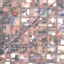

-----------------------------------------------------------------------
Confidence Score: 9.634322166442871 Predicted Class: Highway Actual Class: River


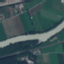

-----------------------------------------------------------------------
Confidence Score: 8.971275329589844 Predicted Class: River Actual Class: Highway


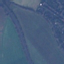

-----------------------------------------------------------------------
Confidence Score: 8.936596870422363 Predicted Class: Highway Actual Class: River


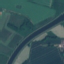

-----------------------------------------------------------------------


In [21]:
#visualize 4 wrong prediction
op_name=['AnnualCrop','Forest','HerbaceousVegetation','Highway','Industrial','Pasture','PermanentCrop','Residential','River','SeaLake']
list1.sort(reverse=True)
for i in range(4):
  print('Confidence Score:',list1[i][0].item(),'Predicted Class:',op_name[list1[i][2].item()],'Actual Class:',op_name[list1[i][3].item()])
  display(list1[i][1])
  print('-----------------------------------------------------------------------')

In [22]:
#classification report on test dataset
labels= [val[1] for val in test_set]

print(classification_report(np.array(labels),np.array(prediction)))

              precision    recall  f1-score   support

           0       0.95      0.94      0.95       600
           1       0.99      0.99      0.99       600
           2       0.93      0.96      0.95       600
           3       0.95      0.93      0.94       500
           4       0.98      0.97      0.98       500
           5       0.91      0.95      0.93       400
           6       0.97      0.88      0.92       500
           7       0.97      0.99      0.98       600
           8       0.94      0.95      0.94       500
           9       0.99      1.00      0.99       600

    accuracy                           0.96      5400
   macro avg       0.96      0.96      0.96      5400
weighted avg       0.96      0.96      0.96      5400



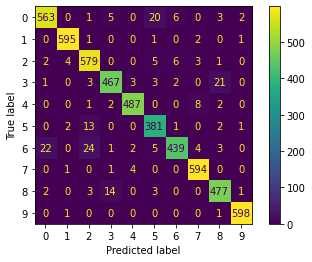

In [23]:
#heatmap for test dataset
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
cm = confusion_matrix(labels, prediction)
disp = ConfusionMatrixDisplay(confusion_matrix=cm)
disp.plot()

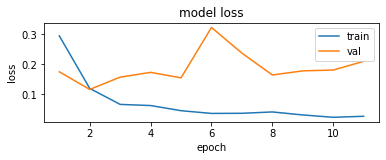

In [24]:
import matplotlib.pyplot as plt
epochs=list(range(1,len(best_train_acc)+1))
plt.subplot(2,1,1)
plt.plot(epochs,best_train_losses,label='train')
plt.plot(epochs,best_val_losses,label='val')
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend()

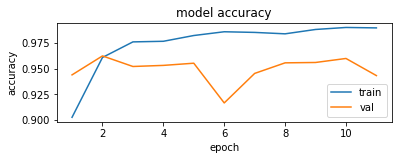

In [25]:
epochs=list(range(1,len(best_train_acc)+1))
plt.subplot(2,1,1)
plt.plot(epochs,best_train_acc,label='train')
plt.plot(epochs,best_val_acc,label='val')
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend()

In [26]:
ids=[i for i in range(len(test_loader.dataset))]
my_submission = pd.DataFrame({'id': ids, 'label': prediction})
my_submission.to_csv('submission_task2a.csv', index=False)

# Resnet(pretrained=False)

In [27]:
#import the resnet model with pretrained false
resnet_not_pretrained_model = models.resnet18(pretrained=False)
num_inp = resnet_not_pretrained_model.fc.in_features
resnet_not_pretrained_model.fc = nn.Linear(num_inp, 10)



In [28]:
train_losses=[]
val_losses=[]
train_acc=[]
val_acc=[]
resnet_not_pretrained_model=resnet_not_pretrained_model.to(device)
opt=torch.optim.Adam(resnet_not_pretrained_model.parameters(),lr=0.0002) #we are getting best accuracy at lr=0.0002 for resnet(pretrained=True). Thus using the same lr for resnet(pretrained=False)
resnet_not_pretrained_model,_=train_model(resnet_not_pretrained_model,NBATCH,patience,n_epochs,opt,train_losses,val_losses,train_acc,val_acc,model_name1)
    

/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:481: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))


EPOCH: 1/50
Train loss: 0.83911, Train accuracy: 0.69620
Val loss: 0.76966, Val accuracy: 0.72756

EPOCH: 2/50
Train loss: 0.55609, Train accuracy: 0.79901
Val loss: 1.17473, Val accuracy: 0.60150

EPOCH: 3/50
Train loss: 0.41713, Train accuracy: 0.85052
Val loss: 1.19258, Val accuracy: 0.68732

EPOCH: 4/50
Train loss: 0.33437, Train accuracy: 0.88218
Val loss: 1.49593, Val accuracy: 0.63782

EPOCH: 5/50
Train loss: 0.24457, Train accuracy: 0.91161
Val loss: 1.35389, Val accuracy: 0.67379

EPOCH: 6/50
Train loss: 0.19562, Train accuracy: 0.93125
Val loss: 0.83870, Val accuracy: 0.75748

EPOCH: 7/50
Train loss: 0.17102, Train accuracy: 0.93806
Val loss: 0.66333, Val accuracy: 0.80876

EPOCH: 8/50
Train loss: 0.14529, Train accuracy: 0.94758
Val loss: 0.72222, Val accuracy: 0.81375

EPOCH: 9/50
Train loss: 0.12025, Train accuracy: 0.95679
Val loss: 1.38447, Val accuracy: 0.70299

EPOCH: 10/50
Train loss: 0.10769, Train accuracy: 0.96099
Val loss: 1.62690, Val accuracy: 0.65634

EPOCH: 11

In [29]:
#download model 
!wget --load-cookies /tmp/cookies.txt "https://docs.google.com/uc?export=download&confirm=$(wget --quiet --save-cookies /tmp/cookies.txt --keep-session-cookies --no-check-certificate 'https://docs.google.com/uc?export=download&id=1-3LLcZoLYSocA6Wq7HWN2RW032P7QcDJ' -O- | sed -rn 's/.*confirm=([0-9A-Za-z_]+).*/\1\n/p')&id=1-3LLcZoLYSocA6Wq7HWN2RW032P7QcDJ" -O logs_resnet/best_model_not_pretrained.pt && rm -rf /tmp/cookies.txt

--2022-04-05 16:02:16--  https://docs.google.com/uc?export=download&confirm=t&id=1-3LLcZoLYSocA6Wq7HWN2RW032P7QcDJ
Resolving docs.google.com (docs.google.com)... 74.125.129.113, 74.125.129.101, 74.125.129.102, ...
Connecting to docs.google.com (docs.google.com)|74.125.129.113|:443... connected.
HTTP request sent, awaiting response... 303 See Other
Location: https://doc-08-b8-docs.googleusercontent.com/docs/securesc/ha0ro937gcuc7l7deffksulhg5h7mbp1/e5pcjokv2fo19pp5sm5ve2go5njdv8sf/1649174475000/11335180243043672040/*/1-3LLcZoLYSocA6Wq7HWN2RW032P7QcDJ?e=download [following]
--2022-04-05 16:02:16--  https://doc-08-b8-docs.googleusercontent.com/docs/securesc/ha0ro937gcuc7l7deffksulhg5h7mbp1/e5pcjokv2fo19pp5sm5ve2go5njdv8sf/1649174475000/11335180243043672040/*/1-3LLcZoLYSocA6Wq7HWN2RW032P7QcDJ?e=download
Resolving doc-08-b8-docs.googleusercontent.com (doc-08-b8-docs.googleusercontent.com)... 74.125.126.132, 2607:f8b0:4001:c1d::84
Connecting to doc-08-b8-docs.googleusercontent.com (doc-08-b8

In [30]:
checkpoint = torch.load('logs_resnet/best_model_not_pretrained.pt')
resnet_not_pretrained_model.load_state_dict(checkpoint)
resnet_model_not_pretrained=resnet_not_pretrained_model.to(device)

In [31]:
#check the validation accuracy
val_correct=0
with torch.no_grad():
  resnet_model_not_pretrained.eval()
  for (x, y) in val_loader:
    x = x.to(device)
    pred = resnet_model_not_pretrained(x)
    val_correct += (pred.argmax(1).to(device) == y.to(device)).type(torch.float).sum().item()

val_correct = val_correct / len(val_loader.dataset)
print('validation accuracy',val_correct)


/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:481: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))


validation accuracy 0.8087606837606838


In [32]:
#check test accuracy
test_correct=0
import torchvision.transforms.functional as TF
prediction = []
	
with torch.no_grad():
	resnet_model_not_pretrained.eval()
	for (x, y) in test_loader:
		x = x.to(device)
		y=y.to(device)
		pred = resnet_model_not_pretrained(x)
		prediction.extend(pred.argmax(axis=1).cpu().numpy())
		test_correct += (pred.argmax(1).to(device) == y.to(device)).type(torch.float).sum().item()
		
			
test_correct = test_correct / len(test_loader.dataset)
print('Test accuracy',test_correct)



/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:481: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))


Test accuracy 0.8196296296296296


In [33]:
#classification report on test dataset
labels= [val[1] for val in test_set]

print(classification_report(np.array(labels),np.array(prediction)))

              precision    recall  f1-score   support

           0       0.92      0.70      0.80       600
           1       0.96      0.95      0.95       600
           2       0.63      0.83      0.72       600
           3       0.68      0.77      0.72       500
           4       0.93      0.89      0.91       500
           5       0.79      0.80      0.79       400
           6       0.76      0.48      0.59       500
           7       0.91      0.93      0.92       600
           8       0.71      0.88      0.79       500
           9       0.97      0.92      0.94       600

    accuracy                           0.82      5400
   macro avg       0.83      0.81      0.81      5400
weighted avg       0.83      0.82      0.82      5400



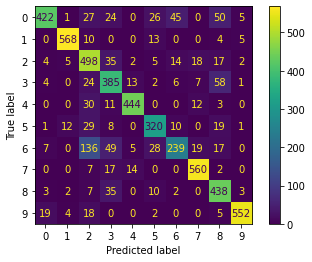

In [34]:
#heatmap for test dataset
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
cm = confusion_matrix(labels, prediction)
disp = ConfusionMatrixDisplay(confusion_matrix=cm)
disp.plot()

In [35]:
ids=[i for i in range(len(test_loader.dataset))]
my_submission = pd.DataFrame({'id': ids, 'label': prediction})
my_submission.to_csv('submission_task2b.csv', index=False)